# Capturing long-term dependencies with LSTMs

In this notebook we will test different configurations of RNNs and see how they perform.

Outline:
1. [Short-distance dataset with 10 periods: Linear model versus Simple RNN](#Section-1.-Short-distance-dataset-with-10-periods:-Linear-model-versus-Simple-RNN)
1. [Long-distance dataset with 10 periods: Simple RNN versus LSTM](#Section-2.-Long-distance-dataset-with-10-periods:-Simple-RNN-versus-LSTM)
1. [Long-distance dataset with 20 periods: Simple RNN versus LSTM versus GRU](#Section-3.-Long-distance-dataset-with-20-periods:-Simple-RNN-versus-LSTM-versus-GRU)
1. [Hitting the limit of the LSTM: use Global Max Pooling](#Section-4.-Hitting-the-limit-of-the-LSTM:-use-Global-Max-Pooling)

In [1]:
%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import utils

In [2]:
utils.print_nb_info()

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.4.0
TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
plt.rc('font', size='12')
plt.rc('mathtext', fontset='cm')
plt.rc('figure', figsize=(6.4, 4.8))

In [4]:
SAVEFIG: bool = True
EXT: str = 'pdf'
FIG_PATH: Path = Path('./out/plots/lstm_distance')
constants: dict = {'save': SAVEFIG, 'extension': EXT, 'fig_path': FIG_PATH}

In [5]:
utils.check_dir(FIG_PATH)

This directory exists: WindowsPath('C:/Users/YBant/Documents/projects/deep_learning/tsa/out/plots/lstm_distance')


In [6]:
cases: tuple = ('short-distance-10', 'long-distance-10', 'long-distance-20', 'long-distance-30')

results: dict = {case: {} for case in cases}

## Section 1. Short-distance dataset with 10 periods: Linear model versus Simple RNN

Just for the sake of replication, I imported my own datasets. However, we should be able to generate them making use of the `utils.generate_distance()` function.

Rows are samples and columns time steps. Thus, a row is a sequence of random values coming from a normal standard distribution for 10 time steps.

In [7]:
data_short10 = pd.read_csv('data/xor10_short.csv', index_col=0)
data_short10

,0,1,2,3,4,5,6,7,8,9,Y
0,-0.347167,0.180646,0.479704,-0.379384,0.591553,0.491876,2.425621,-0.472849,1.176760,-0.891470,0
1,-0.811868,0.368232,-0.820585,-0.763253,1.087861,0.261214,-0.938820,-1.156446,-0.547493,1.477342,0
2,-0.871913,-1.144904,0.590068,0.163802,-0.295389,-0.201298,-0.708277,0.622546,1.283568,1.149649,0
3,-0.690922,-1.730924,-0.054536,0.651995,-0.545174,-1.784856,-0.129548,0.876852,1.044099,-0.822859,1
4,-1.615000,-0.335704,-1.257434,1.094222,-0.589852,-0.770867,0.009162,0.929367,0.115576,1.845343,0
...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.082797,2.417874,-0.355266,-0.850585,0.540557,1.244503,0.509711,0.133651,-0.396447,-0.020277,0
4996,-0.774517,-0.909877,0.562672,-0.218940,0.018033,0.409960,-0.941905,-0.503495,-1.222098,1.993182,0
4997,-1.664744,-1.152928,0.687370,-0.447970,0.243767,-0.095498,-2.392940,-0.496066,-0.497013,-1.311405,1
4998,0.181828,-0.819450,0.293142,-0.485337,0.272713,0.370028,-2.420577,-0.454588,0.017395,0.434477,1


In [8]:
X = data_short10.drop('Y', axis=1).to_numpy()
Y = data_short10['Y'].to_numpy()

N, T = X.shape
D: int = 1

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 10), Y.shape: (5000,)


### Linear model

In [9]:
inputs = Input(shape=(T,))
x = Dense(1, activation='sigmoid')(inputs)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [10]:
results['short-distance-10']['linreg'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

In [11]:
results['short-distance-10']['linreg'].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Figure successfully saved out\plots\lstm_distance\loss_st10_xor_linreg.pdf


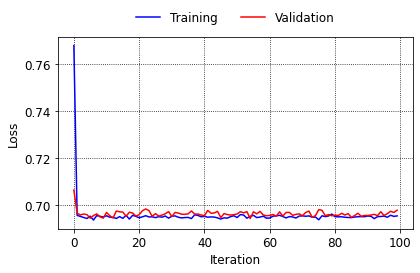

In [12]:
utils.plot_loss(results['short-distance-10']['linreg'].history['loss'], 
                results['short-distance-10']['linreg'].history['val_loss'],
                save=SAVEFIG, imgname='loss_st10_xor_linreg', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_st10_xor_linreg.pdf


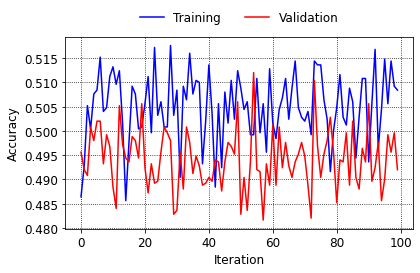

In [13]:
utils.plot_accuracy(results['short-distance-10']['linreg'].history['accuracy'], 
                    results['short-distance-10']['linreg'].history['val_accuracy'],
                    save=SAVEFIG, imgname='accuracy_st10_xor_linreg', fig_path=FIG_PATH)

### Simple RNN

In [14]:
X_3D = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [15]:
results['short-distance-10']['simple-rnn'] = model.fit(X_3D, Y, epochs=100, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_st10_xor_rnn.pdf


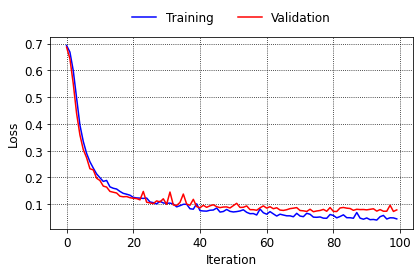

In [16]:
utils.plot_loss(results['short-distance-10']['simple-rnn'].history['loss'], 
                results['short-distance-10']['simple-rnn'].history['val_loss'],
                save=SAVEFIG, imgname='loss_st10_xor_rnn', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_st10_xor_rnn.pdf


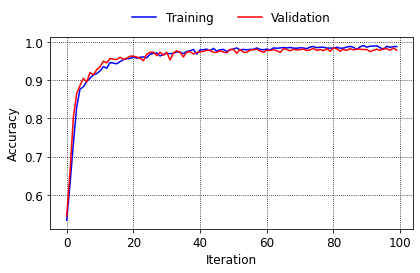

In [17]:
utils.plot_accuracy(results['short-distance-10']['simple-rnn'].history['accuracy'],
                    results['short-distance-10']['simple-rnn'].history['val_accuracy'],
                    save=SAVEFIG, imgname='accuracy_st10_xor_rnn', fig_path=FIG_PATH)

The Simple RNN has low loss and a high accuracy curve. They look good, as expected. Meaning that a Simple RNN can solve this problem. Since the part if the time series that affects the classification result is a the end of the sequence, it does not require any long term memory. Thus, the vanishing gradient problem is not an issue here.

## Section 2. Long-distance dataset with 10 periods: Simple RNN versus LSTM

In [18]:
data_long10 = pd.read_csv('data/xor10_long.csv', index_col=0)
X = data_long10.drop('Y', axis=1).to_numpy()
Y = data_long10['Y'].to_numpy()

N, T = X.shape
D: int = 1
    
X = np.expand_dims(X, -1)  # Needed for RNN input

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 10, 1), Y.shape: (5000,)


In [19]:
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [20]:
results['long-distance-10']['simple-rnn'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt10_xor_rnn.pdf


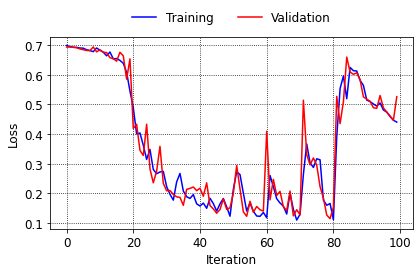

In [21]:
utils.plot_loss(results['long-distance-10']['simple-rnn'].history['loss'],
                results['long-distance-10']['simple-rnn'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt10_xor_rnn', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt10_xor_rnn.pdf


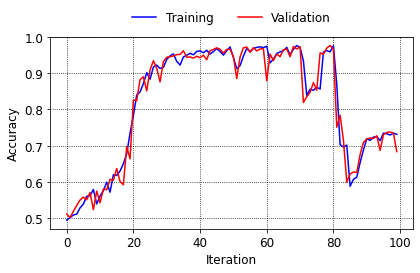

In [22]:
utils.plot_accuracy(results['long-distance-10']['simple-rnn'].history['accuracy'], 
                    results['long-distance-10']['simple-rnn'].history['val_accuracy'],
                    save=SAVEFIG, imgname='accuracy_lt10_xor_rnn', fig_path=FIG_PATH)

In [23]:
inputs = Input(shape=(T, D))
x = LSTM(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [24]:
results['long-distance-10']['lstm'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt10_xor_lstm.pdf


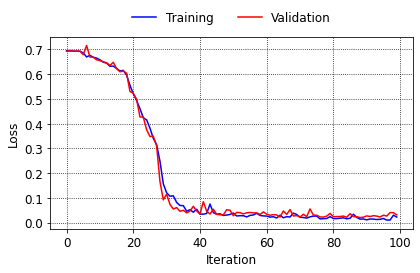

In [25]:
utils.plot_loss(results['long-distance-10']['lstm'].history['loss'],
                results['long-distance-10']['lstm'].history['val_loss'], 
                save=SAVEFIG, imgname='loss_lt10_xor_lstm', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt10_xor_lstm.pdf


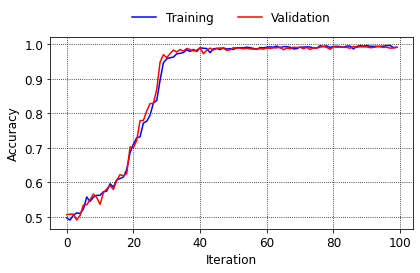

In [26]:
utils.plot_accuracy(results['long-distance-10']['lstm'].history['accuracy'],
                    results['long-distance-10']['lstm'].history['val_accuracy'], 
                    save=SAVEFIG, imgname='accuracy_lt10_xor_lstm', fig_path=FIG_PATH)

## Section 3. Long-distance dataset with 20 periods: Simple RNN versus LSTM versus GRU

### Simple RNN

In [27]:
data_long20 = pd.read_csv('data/xor20_long.csv', index_col=0)
X = data_long20.drop('Y', axis=1).to_numpy()
Y = data_long20['Y'].to_numpy()

N, T = X.shape
D: int = 1
    
X = np.expand_dims(X, -1)  # Needed for RNN input

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 20, 1), Y.shape: (5000,)


In [28]:
inputs = Input(shape=(T, D))
x = SimpleRNN(20)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [29]:
results['long-distance-20']['simple-rnn'] = model.fit(X, Y, epochs=200, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt20_xor_rnn.pdf


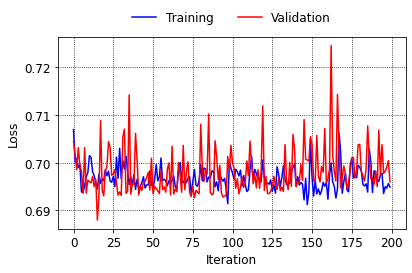

In [30]:
utils.plot_loss(results['long-distance-20']['simple-rnn'].history['loss'],
                results['long-distance-20']['simple-rnn'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt20_xor_rnn', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt20_xor_rnn.pdf


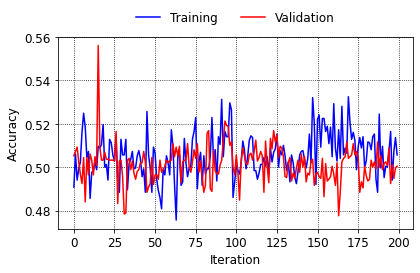

In [31]:
utils.plot_accuracy(results['long-distance-20']['simple-rnn'].history['accuracy'],
                    results['long-distance-20']['simple-rnn'].history['val_accuracy'],
                    save=SAVEFIG, imgname='accuracy_lt20_xor_rnn', fig_path=FIG_PATH)

### LSTM

In [32]:
inputs = Input(shape=(T, D))
x = LSTM(20)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [33]:
results['long-distance-20']['lstm'] = model.fit(X, Y, epochs=200, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt20_xor_lstm.pdf


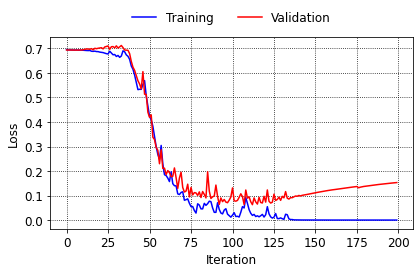

In [34]:
utils.plot_loss(results['long-distance-20']['lstm'].history['loss'],
                results['long-distance-20']['lstm'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt20_xor_lstm', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt20_xor_lstm.pdf


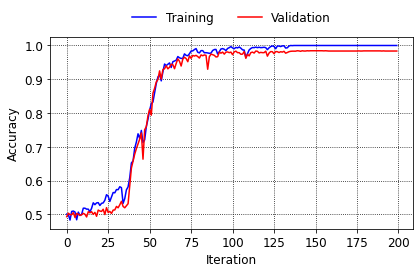

In [35]:
utils.plot_accuracy(results['long-distance-20']['lstm'].history['accuracy'],
                    results['long-distance-20']['lstm'].history['val_accuracy'], 
                    save=SAVEFIG, imgname='accuracy_lt20_xor_lstm', fig_path=FIG_PATH)

### GRU

In [36]:
inputs = Input(shape=(T, D))
x = GRU(20)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [37]:
results['long-distance-20']['gru'] = model.fit(X, Y, epochs=200, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt20_xor_gru.pdf


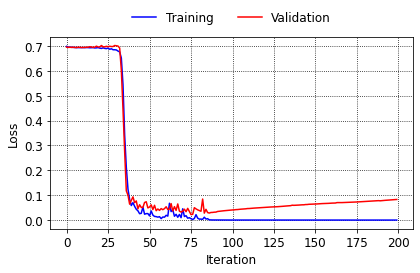

In [38]:
utils.plot_loss(results['long-distance-20']['gru'].history['loss'],
                results['long-distance-20']['gru'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt20_xor_gru', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt20_xor_gru.pdf


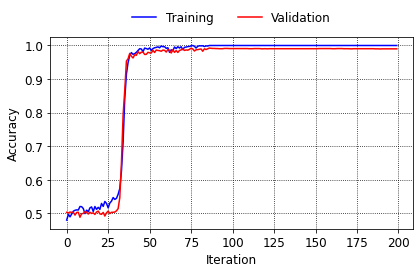

In [39]:
utils.plot_accuracy(results['long-distance-20']['gru'].history['accuracy'],
                    results['long-distance-20']['gru'].history['val_accuracy'], 
                    save=SAVEFIG, imgname='accuracy_lt20_xor_gru', fig_path=FIG_PATH)

## Section 4. Hitting the limit of the LSTM: use Global Max Pooling

### LSTM

In [40]:
data_long30 = pd.read_csv('data/xor30_long.csv', index_col=0)
X = data_long30.drop('Y', axis=1).to_numpy()
Y = data_long30['Y'].to_numpy()

N, T = X.shape
D: int = 1
    
X = np.expand_dims(X, -1)

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 30, 1), Y.shape: (5000,)


In [41]:
inputs = Input(shape=(T, D))

x = LSTM(40)(inputs)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [42]:
results['long-distance-30']['lstm'] = model.fit(X, Y, epochs=400, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt30_xor_lstm.pdf


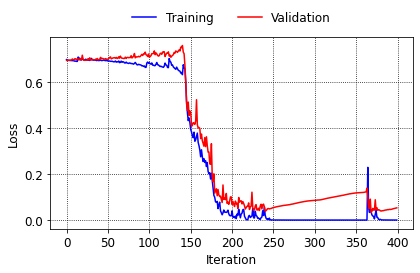

In [43]:
utils.plot_loss(results['long-distance-30']['lstm'].history['loss'],
                results['long-distance-30']['lstm'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt30_xor_lstm', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt30_xor_lstm.pdf


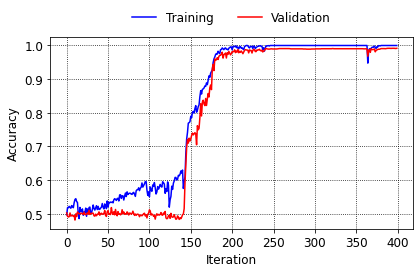

In [44]:
utils.plot_accuracy(results['long-distance-30']['lstm'].history['accuracy'],
                    results['long-distance-30']['lstm'].history['val_accuracy'], 
                    save=SAVEFIG, imgname='accuracy_lt30_xor_lstm', fig_path=FIG_PATH)

### LSTM with GlobalMaxPooling1D

In [45]:
inputs = Input(shape=(T, D))

x = LSTM(40, return_sequences=True)(inputs)
x = GlobalMaxPool1D()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [46]:
results['long-distance-30']['lstm-pool'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt30_xor_lstmpool.pdf


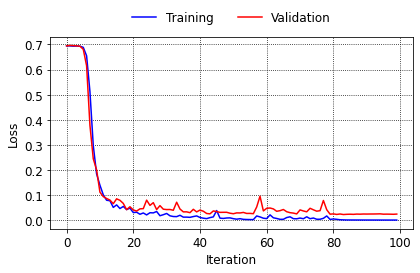

In [47]:
utils.plot_loss(results['long-distance-30']['lstm-pool'].history['loss'],
                results['long-distance-30']['lstm-pool'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt30_xor_lstmpool', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt30_xor_lstmpool.pdf


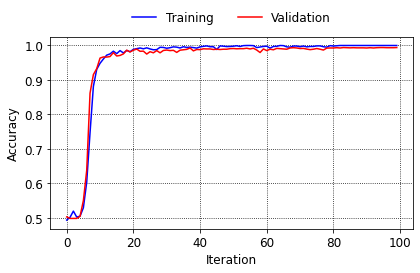

In [48]:
utils.plot_accuracy(results['long-distance-30']['lstm-pool'].history['accuracy'],
                    results['long-distance-30']['lstm-pool'].history['val_accuracy'], 
                    save=SAVEFIG, imgname='accuracy_lt30_xor_lstmpool', fig_path=FIG_PATH)

### GRU

In [49]:
inputs = Input(shape=(T, D))

x = GRU(40)(inputs)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [50]:
results['long-distance-30']['gru'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

Figure successfully saved out\plots\lstm_distance\loss_lt30_xor_gru.pdf


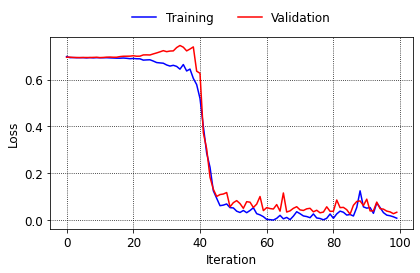

In [51]:
utils.plot_loss(results['long-distance-30']['gru'].history['loss'],
                results['long-distance-30']['gru'].history['val_loss'],
                save=SAVEFIG, imgname='loss_lt30_xor_gru', fig_path=FIG_PATH)

Figure successfully saved out\plots\lstm_distance\accuracy_lt30_xor_gru.pdf


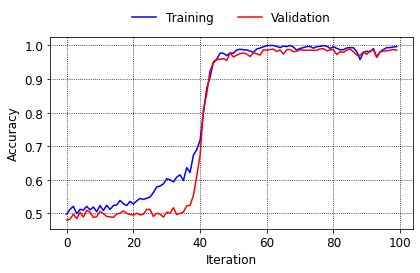

In [52]:
utils.plot_accuracy(results['long-distance-30']['gru'].history['accuracy'],
                    results['long-distance-30']['gru'].history['val_accuracy'], 
                    save=SAVEFIG, imgname='accuracy_lt30_xor_gru', fig_path=FIG_PATH)